In [1]:
# 安装必要工具
import pandas as pd
from google.colab import files

# 上传文件
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# 读取数据
df = pd.read_csv(file_name)

# 显示前几行确认内容
df.head()


Saving twitter_reviews_final_cleaned_v2.csv to twitter_reviews_final_cleaned_v2.csv


,brand,text,created_at,label,cleaned_text
0,Apple,Amazing. Nice product,2024/7/20,positive,amazing nice product
1,Apple,Camerais dam good.,2023/11/10,positive,camerais dam good
2,Apple,Waste phone.,2022/6/6,negative,waste phone
3,Apple,Good. Woooooooow very bootyful camera phone wi...,2024/2/18,positive,good woooooooow bootyful camera phone use dand...
4,Apple,Excellent. Great product,2022/11/18,positive,excellent great product


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 标签编码：positive → 2, neutral → 1, negative → 0（顺序不影响后续训练）
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

# 打印情感标签映射关系
print("标签编码映射：", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# 创建空的训练和验证集列表
train_list = []
val_list = []

# 按品牌进行分组划分（每个品牌保留同样比例）
for brand, group in df.groupby("brand"):
    train, val = train_test_split(
        group,
        test_size=0.2,
        stratify=group["label_encoded"],  # 按照情感标签平衡
        random_state=42
    )
    train_list.append(train)
    val_list.append(val)

# 合并所有品牌的数据
train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)

# 打印数据量确认
print(f"训练集数量: {len(train_df)}")
print(f"验证集数量: {len(val_df)}")


标签编码映射： {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
训练集数量: 9944
验证集数量: 2487


In [4]:
# 安装 transformers（如果还没装）
!pip install transformers -q

from transformers import BertTokenizer

# 加载 BERT 分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 去除空值或仅包含空格的文本行
train_df = train_df[train_df['cleaned_text'].notnull() & (train_df['cleaned_text'].str.strip() != "")]
val_df = val_df[val_df['cleaned_text'].notnull() & (val_df['cleaned_text'].str.strip() != "")]

# 将文本列转为字符串类型并转为列表
train_texts = train_df['cleaned_text'].astype(str).tolist()
val_texts = val_df['cleaned_text'].astype(str).tolist()

# 提取标签
train_labels = train_df['label_encoded'].tolist()
val_labels = val_df['label_encoded'].tolist()

# 编码文本（加 padding 和截断）
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


In [5]:
import torch

# 自定义 PyTorch Dataset 类
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 创建训练集和验证集数据对象
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [8]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import itertools

# 定义评估函数
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# 参数组合
batch_sizes = [16, 32]
learning_rates = [5e-5, 3e-5]
weight_decays = [0.01]
epochs = [2, 3]

# 构建所有组合
param_combinations = list(itertools.product(batch_sizes, learning_rates, weight_decays, epochs))

# 循环训练所有组合
results = []

for i, (batch_size, lr, wd, ep) in enumerate(param_combinations):
    print(f"\n🔁 正在运行第 {i+1}/{len(param_combinations)} 个组合")
    print(f"➡️ 参数：batch_size={batch_size}, learning_rate={lr}, weight_decay={wd}, epochs={ep}")

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(set(train_labels)))

    training_args = TrainingArguments(
        output_dir=f"./results/run_{i}",      # 每组参数保存独立模型
        num_train_epochs=ep,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=32,
        warmup_steps=100,
        weight_decay=wd,
        learning_rate=lr,
        evaluation_strategy="epoch",
        logging_dir=f"./logs/run_{i}",
        logging_steps=50,
        save_strategy="no",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_result = trainer.evaluate()

    # 打印并记录结果
    print(f"✅ 结果：Accuracy={eval_result['eval_accuracy']:.4f}, F1={eval_result['eval_f1']:.4f}")
    results.append({
        "batch_size": batch_size,
        "learning_rate": lr,
        "weight_decay": wd,
        "epochs": ep,
        "accuracy": eval_result["eval_accuracy"],
        "f1": eval_result["eval_f1"]
    })

# 最终输出对比表
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="f1", ascending=False)
print("\n📊 所有参数组合结果（按F1分数排序）：")
print(results_df)



🔁 正在运行第 1/8 个组合
➡️ 参数：batch_size=16, learning_rate=5e-05, weight_decay=0.01, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.460200,0.465101,0.839645,0.806872
2,0.366300,0.444968,0.847703,0.830162


✅ 结果：Accuracy=0.8477, F1=0.8302

🔁 正在运行第 2/8 个组合
➡️ 参数：batch_size=16, learning_rate=5e-05, weight_decay=0.01, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.487400,0.450528,0.842869,0.811485
2,0.382100,0.511081,0.845286,0.822872
3,0.272600,0.524166,0.843674,0.835463


✅ 结果：Accuracy=0.8437, F1=0.8355

🔁 正在运行第 3/8 个组合
➡️ 参数：batch_size=16, learning_rate=3e-05, weight_decay=0.01, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.455200,0.469199,0.839243,0.806767
2,0.366200,0.446941,0.854553,0.828856


✅ 结果：Accuracy=0.8546, F1=0.8289

🔁 正在运行第 4/8 个组合
➡️ 参数：batch_size=16, learning_rate=3e-05, weight_decay=0.01, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.457200,0.479341,0.840451,0.808334
2,0.365700,0.476663,0.852135,0.834621
3,0.265100,0.512348,0.850121,0.842523


✅ 结果：Accuracy=0.8501, F1=0.8425

🔁 正在运行第 5/8 个组合
➡️ 参数：batch_size=32, learning_rate=5e-05, weight_decay=0.01, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.423700,0.458899,0.838840,0.807035
2,0.368100,0.432120,0.851330,0.829425


✅ 结果：Accuracy=0.8513, F1=0.8294

🔁 正在运行第 6/8 个组合
➡️ 参数：batch_size=32, learning_rate=5e-05, weight_decay=0.01, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.440200,0.462197,0.832796,0.797928
2,0.378400,0.449514,0.854150,0.833126
3,0.271300,0.475483,0.850121,0.839805


✅ 结果：Accuracy=0.8501, F1=0.8398

🔁 正在运行第 7/8 个组合
➡️ 参数：batch_size=32, learning_rate=3e-05, weight_decay=0.01, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.427100,0.459002,0.838034,0.808484
2,0.375700,0.439744,0.855761,0.830395


✅ 结果：Accuracy=0.8558, F1=0.8304

🔁 正在运行第 8/8 个组合
➡️ 参数：batch_size=32, learning_rate=3e-05, weight_decay=0.01, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.432300,0.457176,0.834408,0.803511
2,0.380900,0.450783,0.846898,0.824602
3,0.303900,0.469090,0.850524,0.836772


✅ 结果：Accuracy=0.8505, F1=0.8368

📊 所有参数组合结果（按F1分数排序）：
   batch_size  learning_rate  weight_decay  epochs  accuracy        f1
3          16        0.00003          0.01       3  0.850121  0.842523
5          32        0.00005          0.01       3  0.850121  0.839805
7          32        0.00003          0.01       3  0.850524  0.836772
1          16        0.00005          0.01       3  0.843674  0.835463
6          32        0.00003          0.01       2  0.855761  0.830395
0          16        0.00005          0.01       2  0.847703  0.830162
4          32        0.00005          0.01       2  0.851330  0.829425
2          16        0.00003          0.01       2  0.854553  0.828856


In [9]:
# 如果你之前没有统计过，可以直接运行
from collections import Counter

label_distribution = Counter(df['label'])  # 原始数据集中，统计三类标签数量
print("标签分布：", label_distribution)


标签分布： Counter({'positive': 9369, 'negative': 2338, 'neutral': 724})


In [11]:
import pandas as pd

# 所有组合的结果（含运行时间）
results = [
    {"batch_size": 16, "learning_rate": 5e-5, "epochs": 2, "accuracy": 0.8477, "f1": 0.8302, "time_min": 7.25},
    {"batch_size": 16, "learning_rate": 5e-5, "epochs": 3, "accuracy": 0.8437, "f1": 0.8355, "time_min": 10.9},
    {"batch_size": 16, "learning_rate": 3e-5, "epochs": 2, "accuracy": 0.8546, "f1": 0.8289, "time_min": 7.25},
    {"batch_size": 16, "learning_rate": 3e-5, "epochs": 3, "accuracy": 0.8501, "f1": 0.8425, "time_min": 10.9},
    {"batch_size": 32, "learning_rate": 5e-5, "epochs": 2, "accuracy": 0.8513, "f1": 0.8294, "time_min": 6.57},
    {"batch_size": 32, "learning_rate": 5e-5, "epochs": 3, "accuracy": 0.8501, "f1": 0.8398, "time_min": 9.85},
    {"batch_size": 32, "learning_rate": 3e-5, "epochs": 2, "accuracy": 0.8558, "f1": 0.8304, "time_min": 6.57},
    {"batch_size": 32, "learning_rate": 3e-5, "epochs": 3, "accuracy": 0.8505, "f1": 0.8368, "time_min": 9.85},
]

results_df = pd.DataFrame(results)
results_df["config"] = results_df.apply(
    lambda row: f"bs={row['batch_size']},lr={row['learning_rate']:.0e},ep={row['epochs']}", axis=1
)
results_df = results_df.sort_values(by="f1", ascending=False)
results_df


,batch_size,learning_rate,epochs,accuracy,f1,time_min,config
3,16,0.00003,3,0.8501,0.8425,10.90,"bs=16.0,lr=3e-05,ep=3.0"
5,32,0.00005,3,0.8501,0.8398,9.85,"bs=32.0,lr=5e-05,ep=3.0"
7,32,0.00003,3,0.8505,0.8368,9.85,"bs=32.0,lr=3e-05,ep=3.0"
1,16,0.00005,3,0.8437,0.8355,10.90,"bs=16.0,lr=5e-05,ep=3.0"
6,32,0.00003,2,0.8558,0.8304,6.57,"bs=32.0,lr=3e-05,ep=2.0"
0,16,0.00005,2,0.8477,0.8302,7.25,"bs=16.0,lr=5e-05,ep=2.0"
4,32,0.00005,2,0.8513,0.8294,6.57,"bs=32.0,lr=5e-05,ep=2.0"
2,16,0.00003,2,0.8546,0.8289,7.25,"bs=16.0,lr=3e-05,ep=2.0"


<ipython-input-12-5e7437033739>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="config", y="f1", palette="Blues_d")


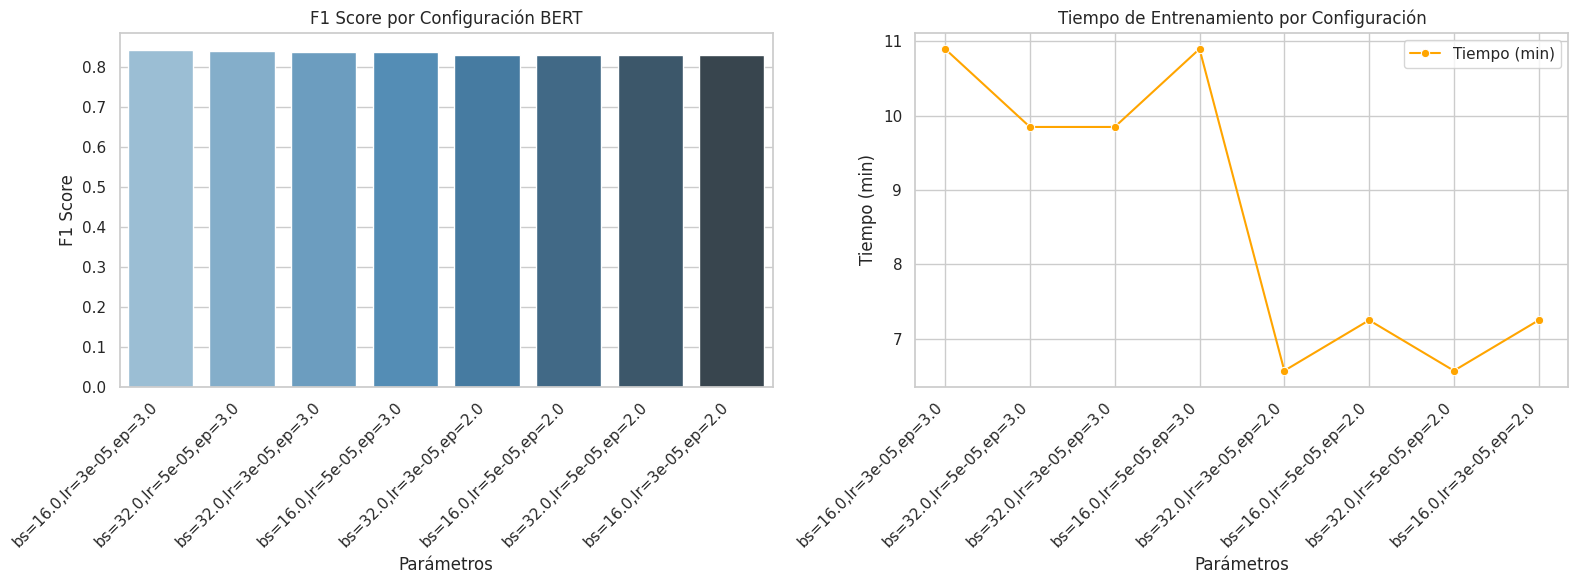

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

# ===== F1 Score 柱状图 =====
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x="config", y="f1", palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.title("F1 Score por Configuración BERT")
plt.xlabel("Parámetros")
plt.ylabel("F1 Score")

# ===== 训练时间线图 =====
plt.subplot(1, 2, 2)
sns.lineplot(data=results_df, x="config", y="time_min", marker="o", label="Tiempo (min)", color="orange")
plt.xticks(rotation=45, ha="right")
plt.title("Tiempo de Entrenamiento por Configuración")
plt.xlabel("Parámetros")
plt.ylabel("Tiempo (min)")

plt.tight_layout()
plt.show()
